# Notebook 20: Variational autoencoder for the Ising Model with Keras

# Learning Goal

The goal of this notebook is to implement a VAE to learn a generative model of the 2D Ising model. The goal will be to understand how latent variables can capture physical quantities (such as the order parameter) and the effect of hyperparameters on VAE results.

## Overview

In this notebook, we will write a variational autoencoder (VAE) in Keras for the 2D Ising model dataset. The code in this notebook is adapted from (https://blog.keras.io/building-autoencoders-in-keras.html) and reproduces some of the results found in (https://arxiv.org/pdf/1703.02435.pdf). The goal of the notebook is to show how to implement a variational autoencoder in Keras in order to learn effective low-dimensional representations of equilibrium samples drawn from the 2D ferromagnetic Ising model with periodic boundary conditions.

## Structure of the notebook
The notebook is structured as follows.

 1. We load in the Ising dataset
 2. We construct the variational auto encoder model using Keras
 3. We train the model on a training set and then visualize the latent representation
 4. We compare the learned representation with the magnetization order parameter

### Load in the dataset

In [1]:
import pickle
from sklearn.model_selection import train_test_split
import collections

def load_data_set(root="IsingMC/", train_size = 0.5):
    """Loads the Ising dataset in the format required for training the tensorflow VAE
    
    Parameters
    -------
    
    root: str, default = "IsingMC/"
        Location of the directory containing the Ising dataset
    train_size: float, default = 0.5
        Size ratio of the training set. 1-train_size corresponds to the test set size ratio.
        
    """
    # The Ising dataset contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=All.pkl','rb'))
    data = np.unpackbits(data).astype(int).reshape(-1,1600) # decompression of data and casting to int. 
    #data[np.where(data==0)]=-1
    #data =data
    Y = np.hstack([t]*10000 for t in np.arange(0.25,4.01,0.25)) # labels

    # Here we downsample the dataset and use 1000 samples at each temperature
    tmp = np.arange(10000)
    np.random.shuffle(tmp)
    rand_idx=tmp[:10000]
    
    X = np.vstack(data[i*10000:(i+1)*10000][rand_idx] for i, _ in enumerate(np.arange(0.25,4.01,0.25)))
    Y = np.hstack(Y[i*10000:(i+1)*10000][rand_idx] for i, _ in enumerate(np.arange(0.25,4.01,0.25)))
    # Note that data is not currently shuffled
    
    #tmp = np.arange(len(X))
    #np.random.shuffle(tmp)
    #X = X[tmp]
    #Y = Y[tmp]
  
    return X, Y
    

## Constructing a VAE class. 

Here, we implement the VAE in a slightly different way than we did for the MNIST dataset. We have chosen to create a new VAE class that The parameters can be easily changed for new data. 



In [2]:
from __future__ import print_function

import numpy as np
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics, losses
from keras.datasets import mnist

class VAE:
    
    def __init__(self, batch_size=100, original_dim =1600, latent_dim = 100, epochs=50, root="IsingMC/", epsilon=0.5):
        '''
         #Reference
         - Auto-Encoding Variational Bayes
           https://arxiv.org/abs/1312.6114
           This code is taken from Keras VAE tutorial available at https://blog.keras.io/building-autoencoders-in-keras.html
        
        Parameters
        ----------
        
        batch_size : int, default=100
            Size of batches for gradient descent
        original_dim : int, default =1600
            Number of features
        latent_dim: int, default = 100
            Dimensionality of the latent space
        epochs: int, default = 50
            Number of epochs for training
        '''
        self.batch_size = batch_size
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = 256
        self.epochs = epochs
        self.epsilon_std = epsilon
    
    def sampling(self, args):
        ''' Sampling from the latent variables using the means and log-variances'''
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim), mean=0.,
                                  stddev=self.epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def build(self):
        """ This class method constructs the VAE model
        """
        original_dim = self.original_dim
        latent_dim = self.latent_dim
        intermediate_dim = self.intermediate_dim
        
        # encoder
        self.x = Input(shape=(original_dim,))
        h = Dense(intermediate_dim, activation='relu')(self.x)
        self.z_mean = Dense(latent_dim)(h)
        self.z_log_var = Dense(latent_dim)(h)
        
        # note that "output_shape" isn't necessary with the TensorFlow backend
        self.z = Lambda(self.sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])
        
        # we instantiate these layers separately so as to reuse them later
        decoder_h = Dense(intermediate_dim, activation='relu')
        decoder_mean = Dense(original_dim, activation='sigmoid')
        h_decoded = decoder_h(self.z)
        x_decoded_mean = decoder_mean(h_decoded)
        
        #decoder
        decoder_input = Input(shape=(latent_dim,))
        _h_decoded = decoder_h(decoder_input)
        _x_decoded_mean = decoder_mean(_h_decoded)
        
        self.generator = Model(decoder_input, _x_decoded_mean)

        
        # end-to-end VAE model
        self.vae = Model(self.x, x_decoded_mean)
        
        # encoder, from inputs to latent space
        self.encoder = Model(self.x, self.z_mean)
        
        
        
        
        # decoder
        #self.decoder = Model(decoder_input, _x_decoded_mean)
        
        # Compute VAE loss
        self.vae.compile(optimizer='adam', loss=self.vae_loss)
        
        # Prints a summary of the architecture used
        self.vae.summary()
        
    def vae_loss(self, x, x_decoded_mean):
        xent_loss = losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)
        return xent_loss + kl_loss
        
    def train(self, x_train, x_test):
        from sklearn.preprocessing import minmax_scale
        
        x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # flatten each sample out 
        x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
        x_train = minmax_scale(x_train) # this step is required in order to use cross-entropy loss for reconstruction
        x_test = minmax_scale(x_test) # scaling features in 0,1 interval
       
        self.vae.fit(x_train, x_train,
                shuffle=True,
                epochs=self.epochs,
                batch_size=self.batch_size,
                validation_data=(x_test, x_test)
                )

        # build a model to project inputs on the latent space
        #encoder = Model(self.x, self.z_mean)
        
    def predict_latent(self, xnew):
        # build a model to project inputs on the latent space
        return self.encoder.predict(xnew)
    
    def generate_decoding(self, znew):
        # Generate new fantasy particles 
        return self.generator.predict(znew)

Using TensorFlow backend.


## Load the 2D Ising dataset 

In [3]:
import numpy as np
# The y labels are the temperatures in np.arange(0.25,4.01,0.2) at which X was drawn

#Directory where data is stored
root="./IsingData/"
X, Y = load_data_set(root= root)

## Construct a training and a validation set 

In [4]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)
print(xtrain.shape)
print(xtest.shape)

(128000, 1600)
(32000, 1600)


## Construct and train the variational autoencoder model

In [5]:
model = VAE(epochs=10, latent_dim=2, epsilon=0.2) # Choose model parameters
model.build() # Construct VAE model using Keras
model.train(xtrain, xtest) # Trains VAE model based on custom loss function

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1600)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          409856      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

/home/chris/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


Train on 128000 samples, validate on 32000 samples
Epoch 1/10
128000/128000 [==============================] - 29s 225us/step - loss: 0.5995 - val_loss: 0.5165
Epoch 2/10
128000/128000 [==============================] - 28s 222us/step - loss: 0.4989 - val_loss: 0.4916
Epoch 3/10
128000/128000 [==============================] - 28s 221us/step - loss: 0.4810 - val_loss: 0.4753
Epoch 4/10
128000/128000 [==============================] - 28s 220us/step - loss: 0.4750 - val_loss: 0.4716
Epoch 5/10
128000/128000 [==============================] - 28s 222us/step - loss: 0.4721 - val_loss: 0.4694
Epoch 6/10
128000/128000 [==============================] - 28s 221us/step - loss: 0.4674 - val_loss: 0.4625
Epoch 7/10
128000/128000 [==============================] - 28s 222us/step - loss: 0.4629 - val_loss: 0.4599
Epoch 8/10
128000/128000 [==============================] - 28s 220us/step - loss: 0.4587 - val_loss: 0.4546
Epoch 9/10
128000/128000 [==============================] - 28s 219us/step - 

## Encoding samples to latent space:
We predict the latent variable coordinates for the test set:

In [6]:
zpred = model.predict_latent(xtest)
print(zpred.shape)

(32000, 2)


Let's visualize this 2-dimensional space. We also color each sample according to the temperature at which it was drawn. The largest temperature is red ($T=4.0$) and lowest is blue ($T=0.25$).

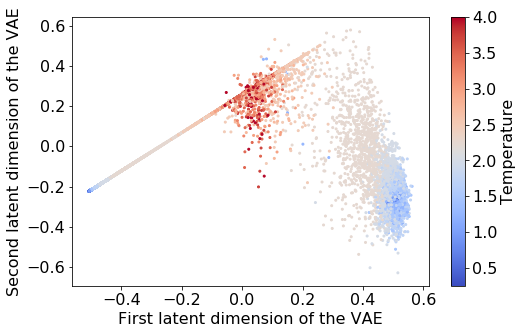

In [41]:
# To make plots pretty
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))


%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,figsize=golden_size(8))
sc = ax.scatter(zpred[:,0], zpred[:,1], c=ytest, s=4, cmap="coolwarm", rasterized=True)
ax.set_xlabel('First latent dimension of the VAE')
ax.set_ylabel('Second latent dimension of the VAE')
plt.colorbar(sc, label='Temperature')
plt.savefig('VAE_ISING_latent.pdf', dpi = 300)
plt.show()

## Understanding the latent space embeddings

To better understand the latent space, we can plot each of the latent dimension coordinates against the corresponding magnetization of each sample.


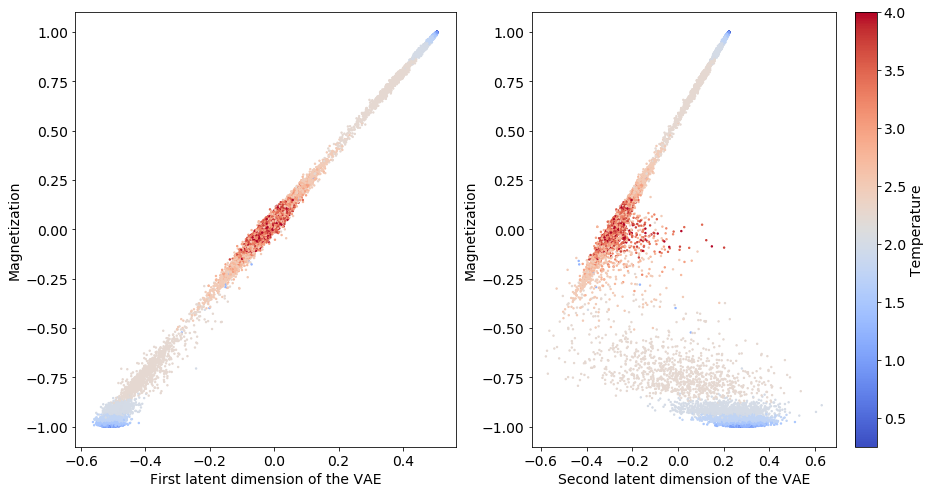

In [42]:
plt.rc('font',**{'size':14})
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].scatter(-zpred[:,0], np.mean(xtest, axis=1)*2-1, c=ytest, s=2, cmap="coolwarm", rasterized=True)
ax[0].set_xlabel('First latent dimension of the VAE')
ax[0].set_ylabel('Magnetization')
sc = ax[1].scatter(-zpred[:,1], np.mean(xtest, axis=1)*2-1, c=ytest, s=2, cmap="coolwarm", rasterized=True)
ax[1].set_xlabel('Second latent dimension of the VAE')
ax[1].set_ylabel('Magnetization')
plt.colorbar(sc, label='Temperature')
plt.savefig('VAE_ISING_latent_magnetization.pdf', dpi = 300)
plt.show()


It appears that these dimensions are strongly correlated, meaning that the learned representation is effectively one-dimensional. This can be understood by the fact that in order to draw samples at high and low temperatures, we only require the information about the magnetization order parameter (we only have to draw samples from a factorized mean-field distribution):
\begin{equation}
p(s_i=\pm) = \frac{1\pm m}{2},
\end{equation}
where $p(s_i=\pm)$ is the probability that spin $i$ is up ($+$) or down ($-$), given that the magnetization sector is fixed.
Note that this is not true in the vicinity of the critical point, where mean-field theory fails as the system develops long-range correlations.

We see that the VAE correctly captures the structure of the data. The high-temperature samples cluster at intermediate values and the ordered samples with positive and negative magnetization cluster in opposite regions. This can be more effectively visualized using a 1-D histogram:

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
PCC = pca.fit_transform(zpred)
print(pca.explained_variance_ratio_)  

[0.67492294 0.3250771 ]


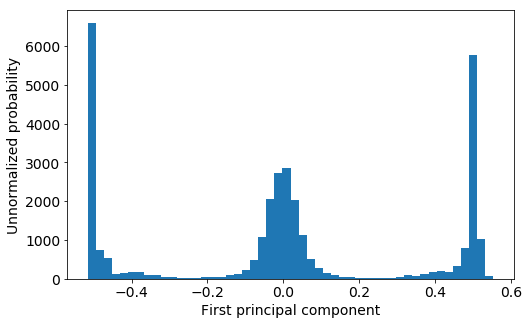

In [44]:
# Make histogram at the 
fig, ax = plt.subplots(1,figsize=golden_size(8))
sc = ax.hist(PCC[:,0],bins=50)
ax.set_xlabel('First principal component')
ax.set_ylabel('Unnormalized probability')
plt.savefig('VAE_ISING_histogram.pdf')
plt.show()

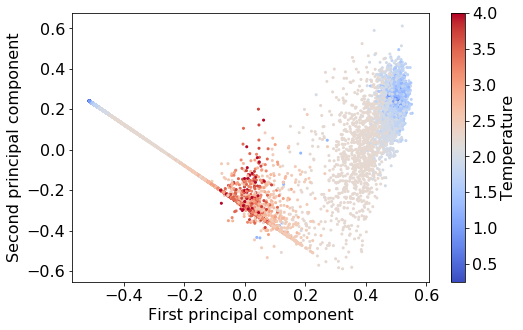

In [45]:
plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,figsize=golden_size(8))
sc = ax.scatter(PCC[:,0],PCC[:,1], c=ytest, s=4, cmap="coolwarm", rasterized=True)
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
plt.colorbar(sc, label='Temperature')
plt.savefig('VAE_ISING_PC1PC2.pdf', dpi = 300)
plt.show()

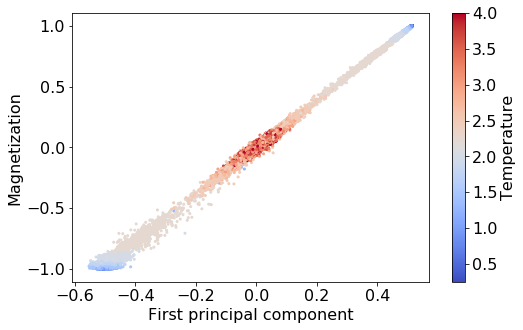

In [46]:
plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,figsize=golden_size(8))
sc = ax.scatter(-PCC[:,0],np.mean(xtest, axis=1)*2-1, c=ytest, s=4, cmap="coolwarm", rasterized=True)
ax.set_xlabel('First principal component')
ax.set_ylabel('Magnetization')
plt.colorbar(sc, label='Temperature')
plt.savefig('VAE_ISING_PC1_magnetization.pdf', dpi=300)
plt.show()

[0.99839675 0.99978742 0.99983099 0.99738038 0.98414795 0.97292518
 0.92811001 0.83112038 0.49437261 0.03066047 0.0116813  0.00649707
 0.00488815 0.00381499 0.0030661  0.00250764]
[ 0.24651749  0.24622278  0.24649315  0.24779049  0.24679607  0.24906033
  0.23307173  0.19069578  0.01783199 -0.26628214 -0.27468178 -0.27570772
 -0.27870387 -0.27671203 -0.27607375 -0.27719867]


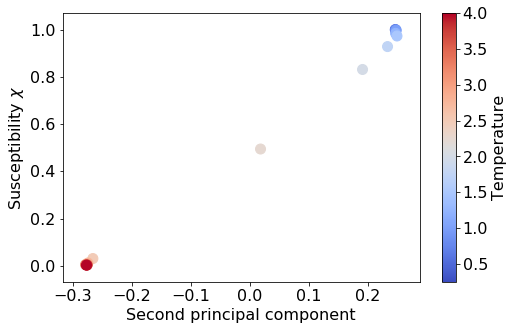

In [53]:
xtest[np.where(xtest==0)]=-1
var = np.zeros(len(np.arange(0.25,4.01, 0.25)))
PCC_average = np.zeros(len(np.arange(0.25,4.01, 0.25)))
for i, T in enumerate(np.arange(0.25,4.01, 0.25)):
    x = xtest[np.where(ytest==T)]
    M = np.mean(x, axis =1)
    var[i] = np.mean(M**2) - np.mean(M)**2
    PCC_average[i] = np.mean(PCC[np.where(ytest==T),1])
    
xtest[np.where(xtest==-1)]=0

print(var)
print(PCC_average)

plt.rc('font',**{'size':16})
fig, ax = plt.subplots(1,figsize=golden_size(8))
sc = ax.scatter(PCC_average,var, c=np.arange(0.25,4.01, 0.25), s=100, cmap="coolwarm")
ax.set_xlabel('Second principal component')
ax.set_ylabel(r'Susceptibility $\chi$')
plt.colorbar(sc, label='Temperature')
plt.savefig('VAE_ISING_variance_PCC2.pdf')
plt.show()

## Generating New Examples

So far in this notebook, we have shown that the latent structure of VAEs can automatically identify order parameters. This is not surprising since even the first principle component in a PCA is essentially the magnetization. 

The interesting feature of VAEs is that they are also a generative model. We now ask how well the VAE can generate new examples. Our decoder returns probabilities for each pixel being 1. We then can draw random numbers to generate samples. This is done in the short function below.

One again, as in the VAE MNIST notebook, we will sample our latent space togenerate the particles in two different ways

* Sampling uniformally in the latent space 
* Sampling accounting for the fact that the latent space is Gaussian so that we expect most of the data points to be centered around (0,0) and fall off exponentially in all directions. This is done by transforming the uniform grid using the inverse Cumulative Distribution Function (CDF) for the Gaussian.


In [14]:
# Generate fantasy particles
def generate_samples(model, z_input):
    temp=model.generate_decoding(z_input).reshape(n*n,1600)
    draws=np.random.uniform(size=temp.shape)
    samples=np.array(draws<temp).astype(int)
    return samples



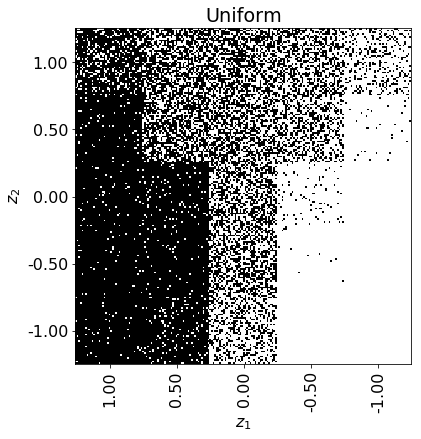

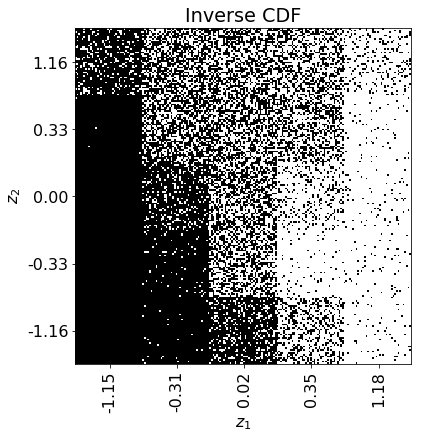

In [54]:
# display a 2D manifold of the images
n = 5  # figure with 15x15 images
quantile_min = 0.01
quantile_max = 0.99
latent_dim=2

img_rows=40
img_cols=40

# Linear Sampling
# we will sample n points within [-15, 15] standard deviations
z1_u = np.linspace(5, -5, n)
z2_u = np.linspace(5, -5, n)
z_grid = np.dstack(np.meshgrid(z1_u, z2_u))
z_input=np.array(z_grid.reshape(n*n, latent_dim))
#print(z_input.shape)
x_pred_grid = generate_samples(model,z_input) \
                     .reshape(n, n, img_rows, img_cols)
    
#print(x_pred_grid)
# Inverse CDF sampling
z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n), loc = np.mean(zpred[:,0]), scale = 0.5)
z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n), loc = np.mean(zpred[:,1]), scale = 0.5)
z_grid2 = np.dstack(np.meshgrid(z1, z2))
z_input=np.array(z_grid2.reshape(n*n, latent_dim))
x_pred_grid2 = generate_samples(model,z_input) \
                     .reshape(n, n, img_rows, img_cols)

    
# Plot figure
fig, ax = plt.subplots(figsize=golden_size(10))

ax.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')

ax.set_xticks(np.arange(0, n*img_rows, img_rows) + .5 * img_rows)
ax.set_xticklabels(map('{:.2f}'.format, z1_u), rotation=90)

ax.set_yticks(np.arange(0, n*img_cols, img_cols) + .5 * img_cols)
ax.set_yticklabels(map('{:.2f}'.format, z2_u))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_title('Uniform')
ax.grid(False)


plt.savefig('VAE_ISING_fantasy_uniform.pdf')
plt.show()


# Plot figure Inverse CDF sampling
fig, ax = plt.subplots(figsize=golden_size(10))

ax.imshow(np.block(list(map(list, x_pred_grid2))), cmap='gray_r', vmin=0, vmax=1)

ax.set_xticks(np.arange(0, n*img_rows, img_rows) + .5 * img_rows)
ax.set_xticklabels(map('{:.2f}'.format, z1), rotation=90)

ax.set_yticks(np.arange(0, n*img_cols, img_cols) + .5 * img_cols)
ax.set_yticklabels(map('{:.2f}'.format, z2))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_title('Inverse CDF')
ax.grid(False)
plt.savefig('VAE_ISING_fantasy_invCDF.pdf')
plt.show()


## Examples fail to capture critial correlations

We see that the examples look quite different from real Ising configurations -- they lack the large scale patchiness seen in the  critical region. They mostly turn out to be unstructured speckles that reflect only the average probability that a pixel is on in a region. This is not surprising since our VAE has no spatial structure and gets very little information about correlations in the binary cross-entropy which we use to measure reconstruction errors.

## Execercises

* To gain more intuition for the VAE parameters, change $\epsilon$. What happens when epsilon is $0.01$, $1$, $10$?
* Change the number of latent dimensions to 1, or 10. Visualize the 10 dimensional latent space using PCA? Are the reconstructed samples and loss functions very different?
* What do you think would happen for other spin systems where the order parameter is a vector such as nematically ordered materials?
* Replace the decoder with a (de)convolutional net that includes spatial structure? Doe this improve the performance of the VAE for generating examples?

In [16]:
round(0.9)

1